In [1]:
# BEWARE
# The dataset used here is not public, so you will not be able to rerun the notebook.

# The dataset used here is ERA5 global historical reanalysis, surface air temperature
# Other variables readily accessible are wind speed at 10m, relative humidity, dew point temperature, precipitation

In [2]:
import sys
sys.path.extend(['./xarray_utilities/', './nbic-workflow/'])

import xarray as xr
import nbic_utils as nbic
import xrutils as xru

import numpy as np

/home/jovyan/./xarray_utilities/xrutils/geo.py:13: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as _gpd


In [3]:
client, cluster = nbic.easi_cluster(number_of_workers=4)

cluster

Uploading wheel /home/jovyan/nbic-workflow/dist/nbic_utils-0.1.0-py3-none-any.whl
Requesting for workers to install ['/home/jovyan/nbic-workflow/dist/nbic_utils-0.1.0-py3-none-any.whl']


In [4]:
import s3fs
s3 = s3fs.S3FileSystem()

In [5]:
files = s3.glob('s3://nbic1-stage-shared-artifacts/ERA5/u10/20*/*.nc')



In [ ]:
%%time
u10 = xr.open_mfdataset([s3.open(f) for f in files], chunks='auto', parallel=True)

In [ ]:
xru.io.tile_to_zarr(u10.u10.chunk( (5000, 100, 100) ), {'time':50000, 'latitude':-1, 'longitude':-1}, 's3://nbic1-stage-shared-artifacts/ERA5/u10/u10.zarr', s3bucket=True)

In [4]:
temp = xr.open_zarr('s3://nbic1-stage-shared-artifacts/).t2m
temp

<xarray.DataArray 't2m' (time: 368928, latitude: 145, longitude: 193)>
dask.array<open_dataset-764568024835d33814b5d38cfd7bc914t2m, shape=(368928, 145, 193), dtype=float32, chunksize=(5000, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -9.0 -9.25 -9.5 -9.75 ... -44.5 -44.75 -45.0
  * longitude  (longitude) float32 110.0 110.2 110.5 110.8 ... 157.5 157.8 158.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-01-31T23:00:00
Attributes:
    long_name:  2 metre temperature
    units:      K

In [5]:
# calculate the daily maximum temperature
daily_max_temp = temp.resample({'time':'1D'}).max() -273.25
daily_max_temp

<xarray.DataArray 't2m' (time: 15372, latitude: 145, longitude: 193)>
dask.array<sub, shape=(15372, 145, 193), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -9.0 -9.25 -9.5 -9.75 ... -44.5 -44.75 -45.0
  * longitude  (longitude) float32 110.0 110.2 110.5 110.8 ... 157.5 157.8 158.0
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-01-31

In [6]:
monthly_idx = daily_max_temp.time.dt.strftime('%Y-%m')
monthly_idx.name = 'months'
monthly_idx

<xarray.DataArray 'months' (time: 15372)>
array(['1979-01', '1979-01', '1979-01', ..., '2021-01', '2021-01',
       '2021-01'], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-01-31

In [7]:
monthly_average_of_daily_max = daily_max_temp.groupby(monthly_idx).mean()

monthly_average_of_daily_max

<xarray.DataArray 't2m' (months: 505, latitude: 145, longitude: 193)>
dask.array<stack, shape=(505, 145, 193), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -9.0 -9.25 -9.5 -9.75 ... -44.5 -44.75 -45.0
  * longitude  (longitude) float32 110.0 110.2 110.5 110.8 ... 157.5 157.8 158.0
  * months     (months) object '1979-01' '1979-02' ... '2020-12' '2021-01'

In [8]:
monthly_average_of_daily_max = monthly_average_of_daily_max.persist()

In [9]:
yearly_average_of_daily_max = daily_max_temp.resample({'time':'1Y'}).mean()
yearly_average_of_daily_max

<xarray.DataArray 't2m' (time: 43, latitude: 145, longitude: 193)>
dask.array<stack, shape=(43, 145, 193), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -9.0 -9.25 -9.5 -9.75 ... -44.5 -44.75 -45.0
  * longitude  (longitude) float32 110.0 110.2 110.5 110.8 ... 157.5 157.8 158.0
  * time       (time) datetime64[ns] 1979-12-31 1980-12-31 ... 2021-12-31

In [10]:
yearly_average_of_daily_max = yearly_average_of_daily_max.persist()
yearly_average_of_daily_max

<xarray.DataArray 't2m' (time: 43, latitude: 145, longitude: 193)>
dask.array<stack, shape=(43, 145, 193), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -9.0 -9.25 -9.5 -9.75 ... -44.5 -44.75 -45.0
  * longitude  (longitude) float32 110.0 110.2 110.5 110.8 ... 157.5 157.8 158.0
  * time       (time) datetime64[ns] 1979-12-31 1980-12-31 ... 2021-12-31

/env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


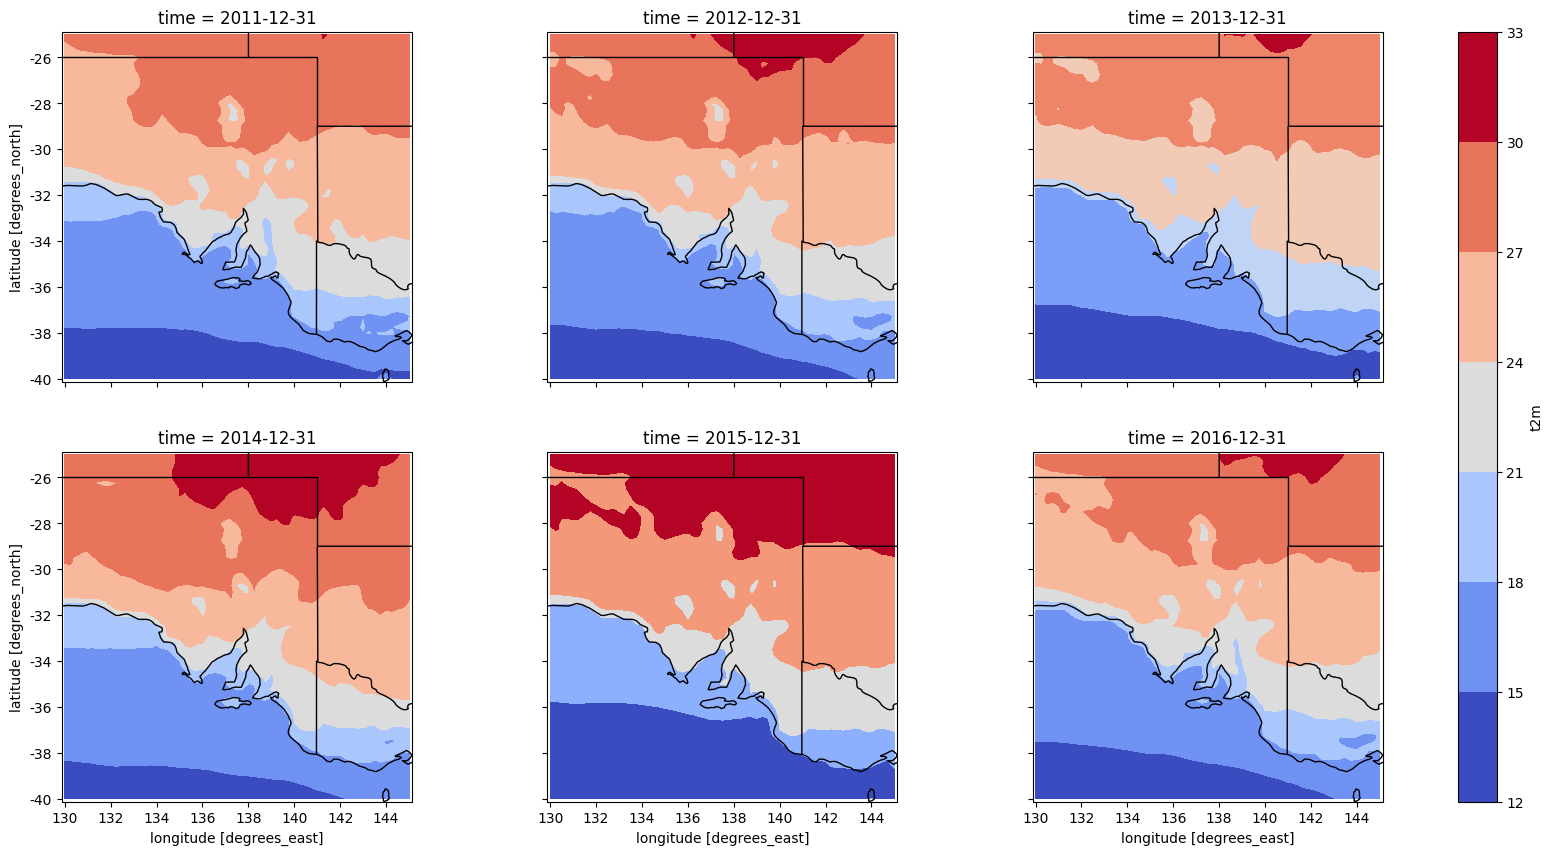

In [11]:
fig = xru.geo.subplots_with_outline(
    yearly_average_of_daily_max.sel(time=slice('2011-12-31', '2016-12-31'), latitude=slice(-25, -40), longitude=slice(130, 145)), 
    col='time', 
    ncols=3, 
    crs=4326,
    cmap='coolwarm',
    # plot_kwargs={'levels':[10, 15, 20, 25, 30, 35]}
)

In [ ]:
fig = xru.geo.subplots_with_outline(
    monthly_average_of_daily_max.sel(months=slice('2012-01', '2014-12'), latitude=slice(-25, -40), longitude=slice(130, 145)), 
    col='months', 
    ncols=3, 
    crs=4326,
    cmap='coolwarm',
    plot_kwargs={'levels':[12, 15, 18, 21, 24, 27, 30, 33]}
)

/env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
